In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
data=pd.read_csv('/kaggle/input/soft-computing-even-id-dataset/training-a.csv')
data

,filename,original filename,scanid,digit,database name original,contributing team,database name
0,a00000.png,Scan_58_digit_5_num_8.png,58,5,BHDDB,Buet_Broncos,training-a
1,a00001.png,Scan_73_digit_3_num_5.png,73,3,BHDDB,Buet_Broncos,training-a
2,a00002.png,Scan_18_digit_1_num_3.png,18,1,BHDDB,Buet_Broncos,training-a
3,a00003.png,Scan_166_digit_7_num_3.png,166,7,BHDDB,Buet_Broncos,training-a
4,a00004.png,Scan_108_digit_0_num_1.png,108,0,BHDDB,Buet_Broncos,training-a
...,...,...,...,...,...,...,...
19697,a19697.png,Scan_81_digit_4_num_3.png,81,4,BHDDB,Buet_Broncos,training-a
19698,a19698.png,Scan_70_digit_3_num_6.png,70,3,BHDDB,Buet_Broncos,training-a
19699,a19699.png,Scan_253_digit_8_num_4.png,253,8,BHDDB,Buet_Broncos,training-a
19700,a19700.png,Scan_27_digit_3_num_6.png,27,3,BHDDB,Buet_Broncos,training-a


In [4]:
np.sort(data['digit'].unique())


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
columnName = data.columns.to_list()
columnName.remove('filename')
columnName.remove('digit')
columnName

['original filename',
 'scanid',
 'database name original',
 'contributing team',
 'database name']

In [6]:
data.drop(columnName,axis='columns', inplace=True)
data

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0
...,...,...
19697,a19697.png,4
19698,a19698.png,3
19699,a19699.png,8
19700,a19700.png,3


In [7]:
import torch
import cv2
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
from PIL import ImageFile
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import torch.nn as nn
import torch.nn.functional as f
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
) 

In [8]:
IMAGE_SIZE = 64
transform = transforms.Compose([
    transforms.ToPILImage(),
    torchvision.transforms.ColorJitter(brightness=0.4,saturation=0.4,contrast=0.4,hue=0.4),
    transforms.RandomRotation(20,expand=True), 
    transforms.Resize(IMAGE_SIZE),  ## image resize
    transforms.CenterCrop(IMAGE_SIZE), ## image center crop
    transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
class EvenIdDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
        image= io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 3]))

        if self.transform:
            image=self.transform(image)
        
        return (image, y_label)

In [10]:
dataset =EvenIdDataset(   
    csv_file="/kaggle/input/soft-computing-even-id-dataset/training-a.csv",

    root_dir="/kaggle/input/soft-computing-even-id-dataset/training-a",
    transform=transform,
)

In [11]:
train_split = 0.2
dataset_size = len(dataset)
batch_size = 25
test_size = int(train_split * dataset_size)
train_size = dataset_size - test_size
train_size

15762

In [12]:
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)  
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [13]:
len(train_set)

15762

In [14]:
num_iters = 20000
input_dim = IMAGE_SIZE*IMAGE_SIZE # num_features = 784
num_hidden = 200 # num of hidden nodes
output_dim = 10
learning_rate = 0.01  # More power so we can learn faster! previously it was 0.001

In [15]:
len(train_set) /batch_size

630.48

In [16]:
num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)
num_epochs

31

In [17]:
type(train_loader)


torch.utils.data.dataloader.DataLoader

In [18]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
images.shape


torch.Size([25, 3, 64, 64])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """


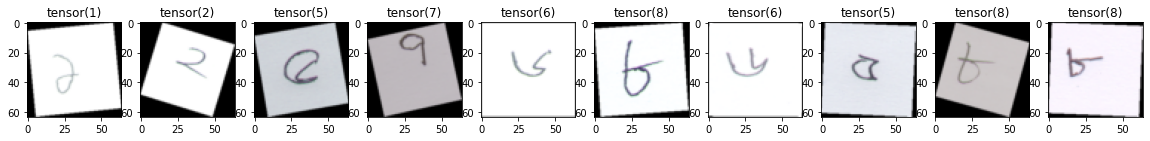

In [19]:
dataiter = iter(train_loader)
images, labels = dataiter.next() 
plt.subplots(figsize=(20, 32))
for i in range(10):
    plt.subplot(10/2, 10,i+1)
    img = images[i].detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5]) 
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.title(labels[i])
    # print(img.shape)
    plt.imshow(img)
plt.show()


In [20]:
 class DeepNeuralNetworkModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1=nn.Linear(3*input_dim, num_hidden)  #flatten the image 
        self.fc2=nn.Linear(num_hidden,num_hidden)
        self.fc3=nn.Linear(num_hidden,num_hidden)
        self.fc4=nn.Linear(num_hidden,num_hidden)  
        self.fc5=nn.Linear(num_hidden,num_hidden)
        self.fc6=nn.Linear(num_hidden,10)
        
    def forward(self,x): # pass the data
        
        x=f.relu(self.fc1(x))
        x=f.relu(self.fc2(x))
        x=f.relu(self.fc3(x))
        x=f.relu(self.fc4(x))
        x=f.relu(self.fc5(x))
        
        x=self.fc6(x)
        
        return x

In [21]:
net = DeepNeuralNetworkModel()
net

DeepNeuralNetworkModel(
  (fc1): Linear(in_features=12288, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=10, bias=True)
)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

DeepNeuralNetworkModel(
  (fc1): Linear(in_features=12288, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=10, bias=True)
)

In [23]:
optimizer =  optim.SGD(net.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [24]:
iteration_loss= []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 3*input_dim).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = net(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 400 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 3*input_dim).to(device)

                # Forward pass only to get logits/output
                outputs = net(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 400. Loss: 2.303595542907715. Accuracy: 9.796954314720812
Iteration: 800. Loss: 2.3038086891174316. Accuracy: 9.796954314720812
Iteration: 1200. Loss: 2.3065989017486572. Accuracy: 10.583756345177665
Iteration: 1600. Loss: 2.3058865070343018. Accuracy: 10.050761421319796
Iteration: 2000. Loss: 2.301711320877075. Accuracy: 9.746192893401016
Iteration: 2400. Loss: 2.3048312664031982. Accuracy: 10.431472081218274
Iteration: 2800. Loss: 2.299879550933838. Accuracy: 11.040609137055837
Iteration: 3200. Loss: 2.3003621101379395. Accuracy: 10.685279187817258
Iteration: 3600. Loss: 2.3025190830230713. Accuracy: 10.558375634517766
Iteration: 4000. Loss: 2.3029978275299072. Accuracy: 10.939086294416244
Iteration: 4400. Loss: 2.2938060760498047. Accuracy: 12.258883248730964
Iteration: 4800. Loss: 2.2905406951904297. Accuracy: 11.446700507614214
Iteration: 5200. Loss: 2.2901723384857178. Accuracy: 12.99492385786802
Iteration: 5600. Loss: 2.2869536876678467. Accuracy: 12.055837563451776
I

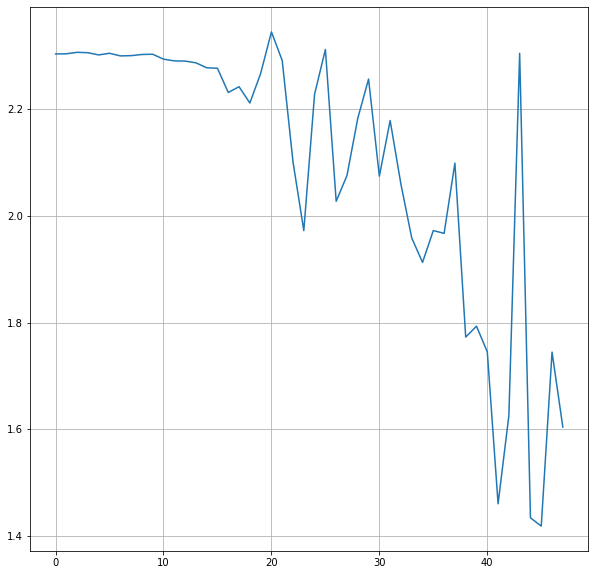

In [25]:
plt.figure(figsize=(10, 10))
plt.plot(iteration_loss, label='Loss')
plt.grid()
plt.show()

In [26]:
train_split = 0.2
dataset_size = len(dataset)
batch_size = 25
test_size = int(train_split * dataset_size)
train_size = dataset_size - test_size
train_size

15762

In [27]:
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)  
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [28]:
num_iters = 30000
input_dim = IMAGE_SIZE*IMAGE_SIZE # num_features = 784
num_hidden = 300 # num of hidden nodes
output_dim = 10
learning_rate = 0.1  # More power so we can learn faster! previously it was 0.001

In [29]:
num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)
num_epochs

47

In [30]:
 class DeepNeuralNetworkModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1=nn.Linear(3*input_dim, num_hidden)  #flatten the image 
        self.fc2=nn.Linear(num_hidden,num_hidden)
        self.fc3=nn.Linear(num_hidden,num_hidden)
        self.fc4=nn.Linear(num_hidden,num_hidden)  
        self.fc5=nn.Linear(num_hidden,num_hidden)
        self.fc6=nn.Linear(num_hidden,10)
        
    def forward(self,x): # pass the data
        
        x=f.relu(self.fc1(x))
        x=f.relu(self.fc2(x))
        x=f.relu(self.fc3(x))
        x=f.relu(self.fc4(x))
        x=f.relu(self.fc5(x))
        
        x=self.fc6(x)
        
        return x

In [31]:
net = DeepNeuralNetworkModel()
net

DeepNeuralNetworkModel(
  (fc1): Linear(in_features=12288, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=300, bias=True)
  (fc5): Linear(in_features=300, out_features=300, bias=True)
  (fc6): Linear(in_features=300, out_features=10, bias=True)
)

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [33]:
optimizer =  optim.SGD(net.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [34]:
iteration_loss2= []
iter = 0
net.to(device)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 3*input_dim).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = net(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 400 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 3*input_dim).to(device)

                # Forward pass only to get logits/output
                outputs = net(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss2.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 400. Loss: 2.3053722381591797. Accuracy: 10.48223350253807
Iteration: 800. Loss: 2.290292978286743. Accuracy: 9.695431472081218
Iteration: 1200. Loss: 2.293987512588501. Accuracy: 10.431472081218274
Iteration: 1600. Loss: 2.3123154640197754. Accuracy: 11.700507614213198
Iteration: 2000. Loss: 2.280399799346924. Accuracy: 11.49746192893401
Iteration: 2400. Loss: 2.23063325881958. Accuracy: 12.563451776649746
Iteration: 2800. Loss: 2.142481565475464. Accuracy: 13.781725888324873
Iteration: 3200. Loss: 2.2592971324920654. Accuracy: 11.700507614213198
Iteration: 3600. Loss: 2.1550214290618896. Accuracy: 18.451776649746193
Iteration: 4000. Loss: 2.2284929752349854. Accuracy: 18.85786802030457
Iteration: 4400. Loss: 2.257737159729004. Accuracy: 18.781725888324875
Iteration: 4800. Loss: 2.1174306869506836. Accuracy: 19.695431472081218
Iteration: 5200. Loss: 2.2771427631378174. Accuracy: 23.04568527918782
Iteration: 5600. Loss: 2.195035696029663. Accuracy: 23.65482233502538
Iteratio

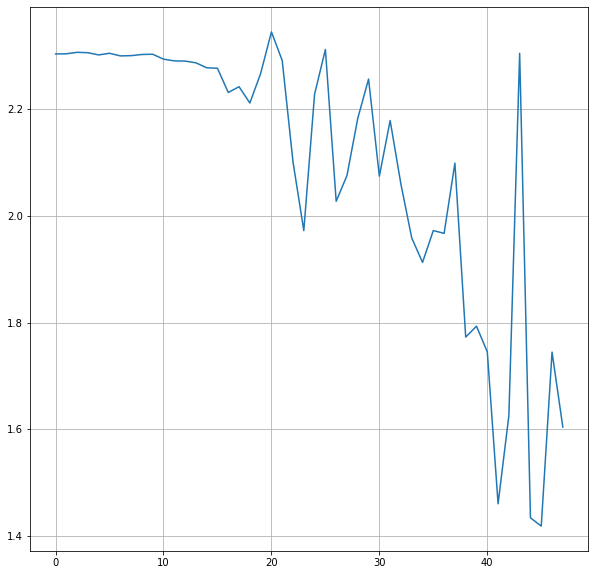

In [35]:
plt.figure(figsize=(10, 10))
plt.plot(iteration_loss, label='Loss')
plt.grid()
plt.show()

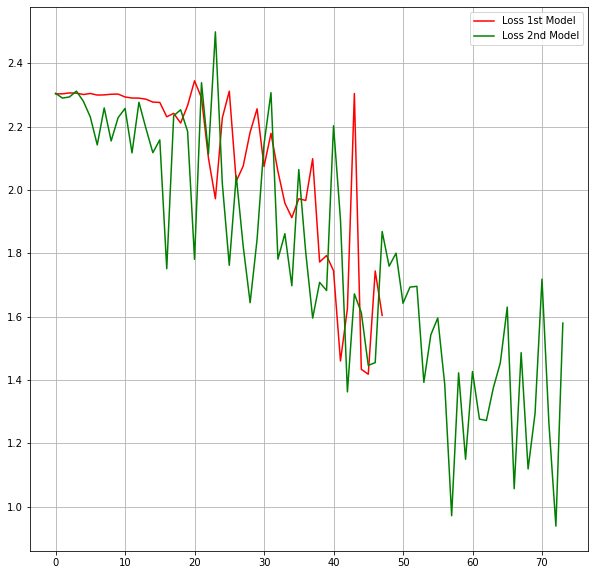

In [36]:
plt.figure(figsize=(10, 10))
plt.plot(iteration_loss, label='Loss 1st Model',color='r')
plt.plot(iteration_loss2, label='Loss 2nd Model',color='g')

plt.legend()
plt.grid()
plt.show()